# Community Crime

This report presents an analysis of a dataset with the objective of forecasting the monthly crime count in Calgary. A neural network model will be employed for predictive modeling, with continuous optimization to enhance accuracy and enable reliable crime prediction for future months.

## Load and understand the data

Dataset URL: "https://raw.githubusercontent.com/cogxen/datasets/main/community-crime-statistics/08022024.csv"

- Import libraries
- Assign the dataset to a varible

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

dataset_url = "https://raw.githubusercontent.com/cogxen/datasets/main/community-crime-statistics/08022024.csv"

2024-08-06 02:50:43.670739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- Load the dataset
- Display the first five (5) rows

In [2]:
crimes = pd.read_csv(dataset_url)
crimes.head(200)

,Community,Category,Crime Count,Year,Month
0,01B,Assault (Non-domestic),1,2022,11
1,01B,Break & Enter - Commercial,1,2019,6
2,01B,Break & Enter - Commercial,1,2019,8
3,01B,Break & Enter - Commercial,2,2020,3
4,01B,Break & Enter - Commercial,2,2020,7
...,...,...,...,...,...
195,02E,Assault (Non-domestic),8,2024,5
196,02E,Break & Enter - Commercial,1,2019,4
197,02E,Break & Enter - Commercial,1,2019,5
198,02E,Break & Enter - Commercial,1,2019,8


Initial analysis indicates that the dataset is sorted alphabetically by the 'Community' column.
 To facilitate accurate analysis, the data must be reordered chronologically.

## Data preprocessing

- Display the shape of the dataset

In [3]:
crimes.shape

(71905, 5)

The dataset comprises approximately **71,905** records distributed across **five (5)** columns. This dataset is considered sufficiently robust for conducting a comprehensive analysis and developing a predictive model.

- Check for missing values

In [4]:
crimes.isnull().sum()

Community      0
Category       0
Crime Count    0
Year           0
Month          0
dtype: int64

The dataset is clean and complete, with no missing values.

- Check the dataset's datatypes

In [5]:
crimes.dtypes

Community      object
Category       object
Crime Count     int64
Year            int64
Month           int64
dtype: object

Columns have correct datatype.

- Preview the summary statistics

In [6]:
crimes.describe()

,Crime Count,Year,Month
count,71905.000000,71905.00000,71905.000000
mean,2.841318,2020.67681,6.351158
std,3.647733,1.86206,3.425845
min,1.000000,2018.00000,1.000000
25%,1.000000,2019.00000,3.000000
50%,2.000000,2021.00000,6.000000
75%,3.000000,2022.00000,9.000000
max,111.000000,2024.00000,12.000000


## Exploratory Data Analysis (EDA)

This analysis will delve into the dataset to identify underlying trends and patterns. These insights will inform the development of a robust predictive model.

### Community Crime Rate Distribution
- Top ten (10) communities with highest crime rate
- Top ten (10) communities with lowest crime rate 

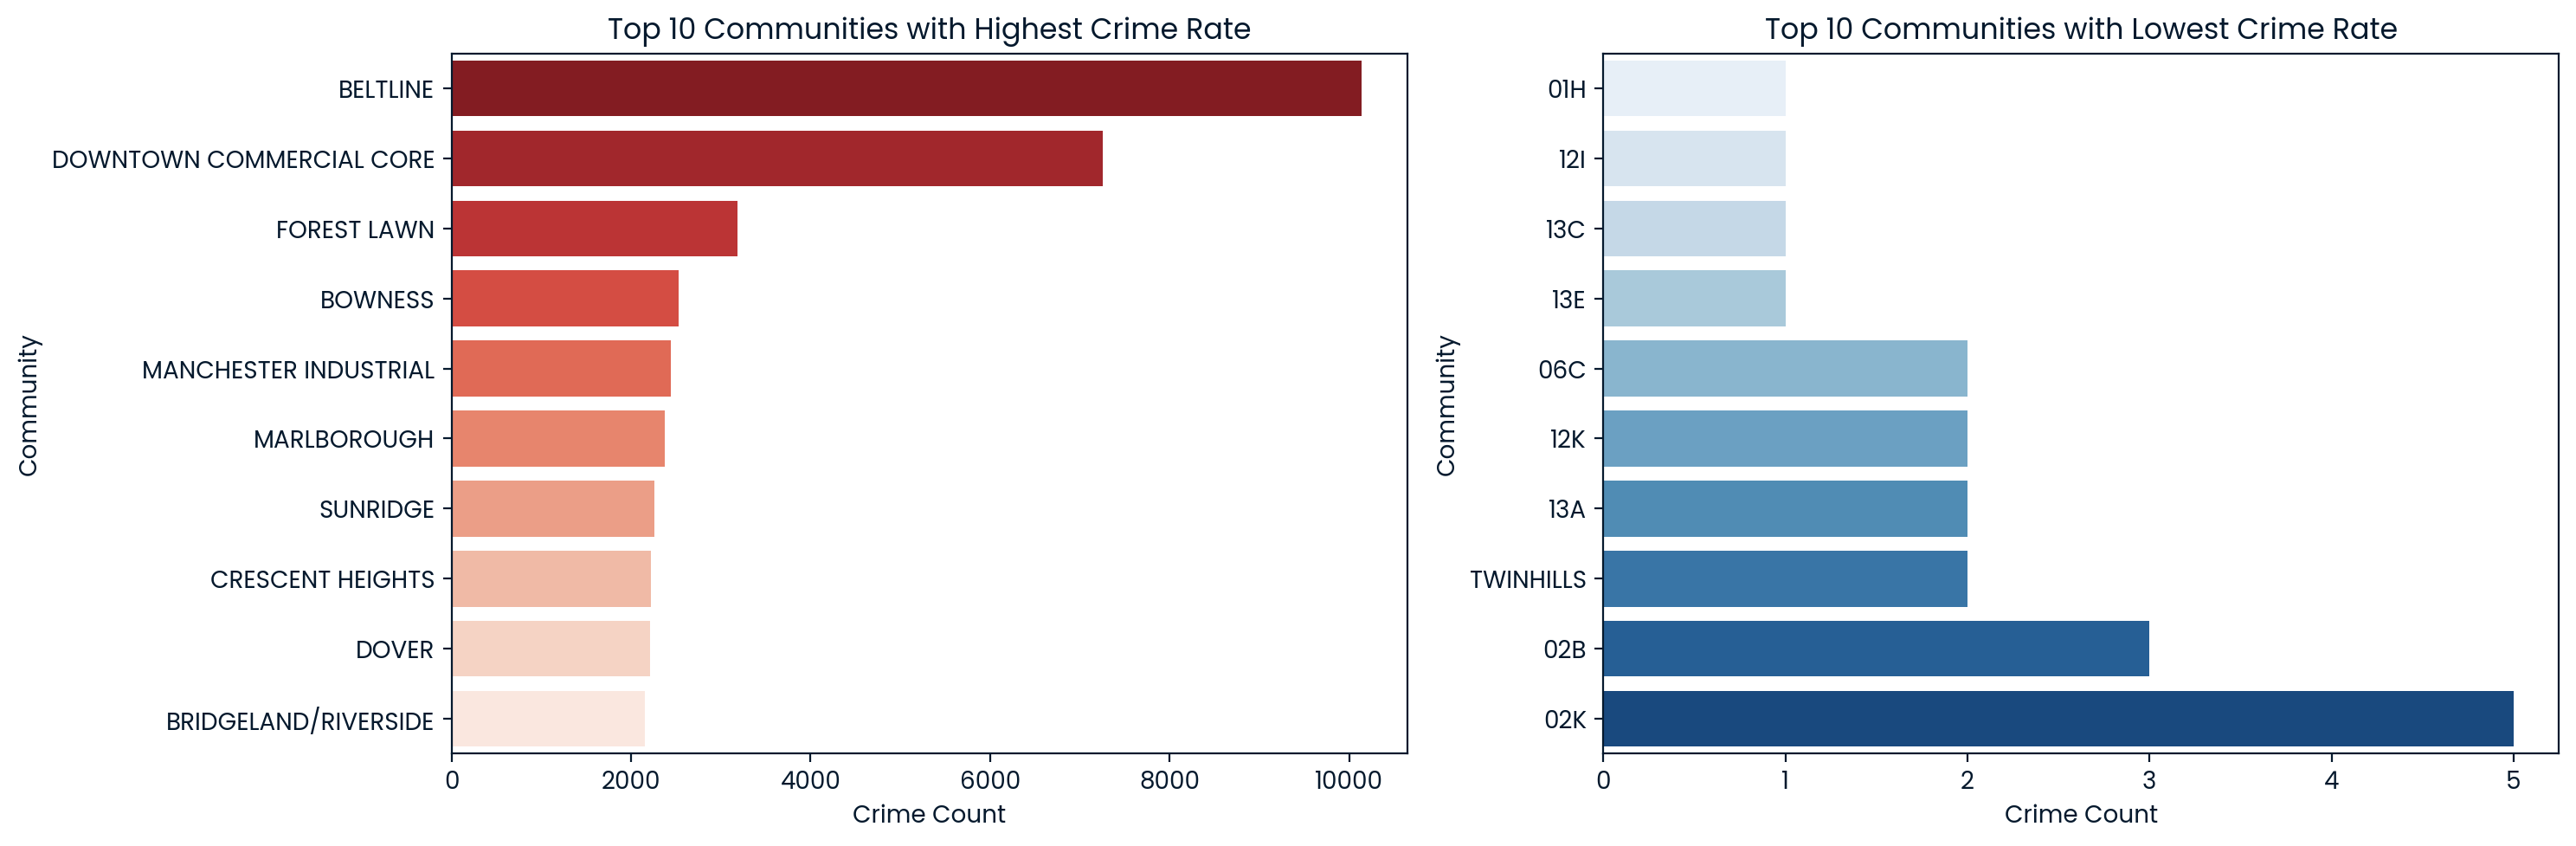

In [7]:
# Aggregate crime counts by community
community_crime_counts = crimes.groupby('Community')['Crime Count'].sum().reset_index()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Top 10 communities with highest crime rate
top_10_highest = community_crime_counts.nlargest(10, "Crime Count")
sns.barplot(y="Community", x="Crime Count", data=top_10_highest, ax=ax[0], palette="Reds_r")
ax[0].set_title("Top 10 Communities with Highest Crime Rate")
ax[0].set_xlabel("Crime Count")
ax[0].set_ylabel("Community")

# Top 10 communities with lowest crime rate
top_10_lowest = community_crime_counts.nsmallest(10, "Crime Count")
sns.barplot(y="Community", x="Crime Count", data=top_10_lowest, ax=ax[1], palette="Blues")
ax[1].set_title("Top 10 Communities with Lowest Crime Rate")
ax[1].set_xlabel("Crime Count")
ax[1].set_ylabel("Community")

plt.tight_layout()
plt.show()

These visualizations illustrate the distribution of crime counts across the listed communities, clearly differentiating high-crime areas (red) from low-crime areas (blue). 

*It is important to note that these findings are unbiased and solely based on the provided dataset.*

### Crime Category Distribution

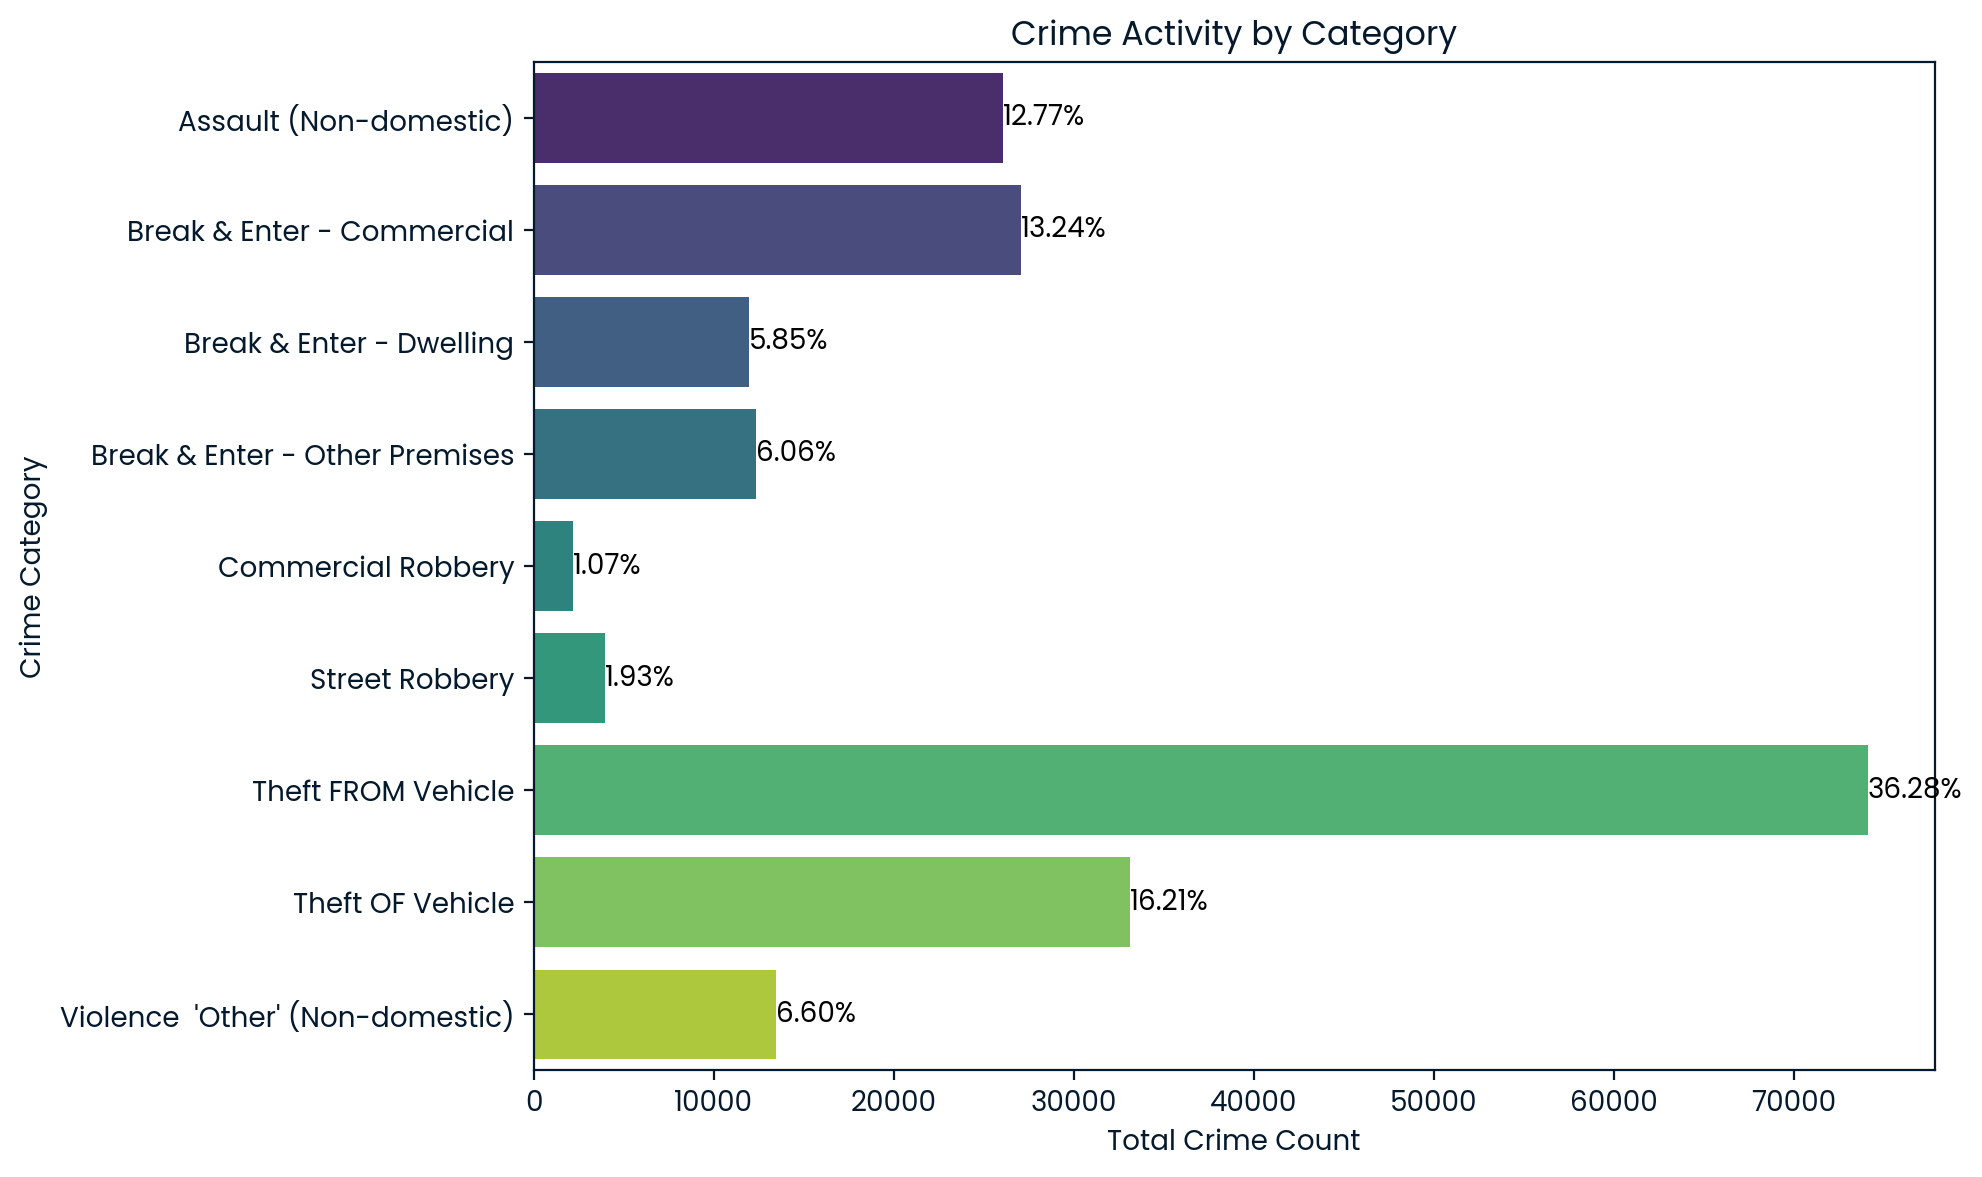

In [8]:
# Aggregate crime counts by category
category_crime_counts = crimes.groupby('Category')['Crime Count'].sum().reset_index()

# Sort by highest to lowest
category_crime_counts = crimes.groupby('Category')['Crime Count'].sum().reset_index()

# Calculate percentage
total_crimes = category_crime_counts['Crime Count'].sum()
category_crime_counts['Percentage'] = (category_crime_counts['Crime Count'] / total_crimes) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x="Crime Count", y="Category", data=category_crime_counts, palette="viridis")

# Add percentage text after the bars
for index, row in category_crime_counts.iterrows():
    plt.text(row['Crime Count'] + 1, index, f"{row['Percentage']:.2f}%", color='black', va="center")

plt.title("Crime Activity by Category")
plt.xlabel("Total Crime Count")
plt.ylabel("Crime Category")
plt.tight_layout()
plt.show()

The graph illustrates the distribution of crime types by frequency. **Theft from Vehicle** is the most prevalent crime, accounting for $36.28\%$ of all incidents, followed by **Theft of Vehicle** at $16.21\%$. Commercial Robbery represents the least frequent crime category.

**Insights:**  
Based on the provided data, it appears that vehicle-related thefts are a significant issue in cities of Calgary. These crimes constitute a substantial portion of the overall crime rate. It would be interesting to explore potential correlations between these crimes and factors such as socioeconomic conditions, population density, or law enforcement resources in different neighborhoods. 

### Crimes Reports Over the Years

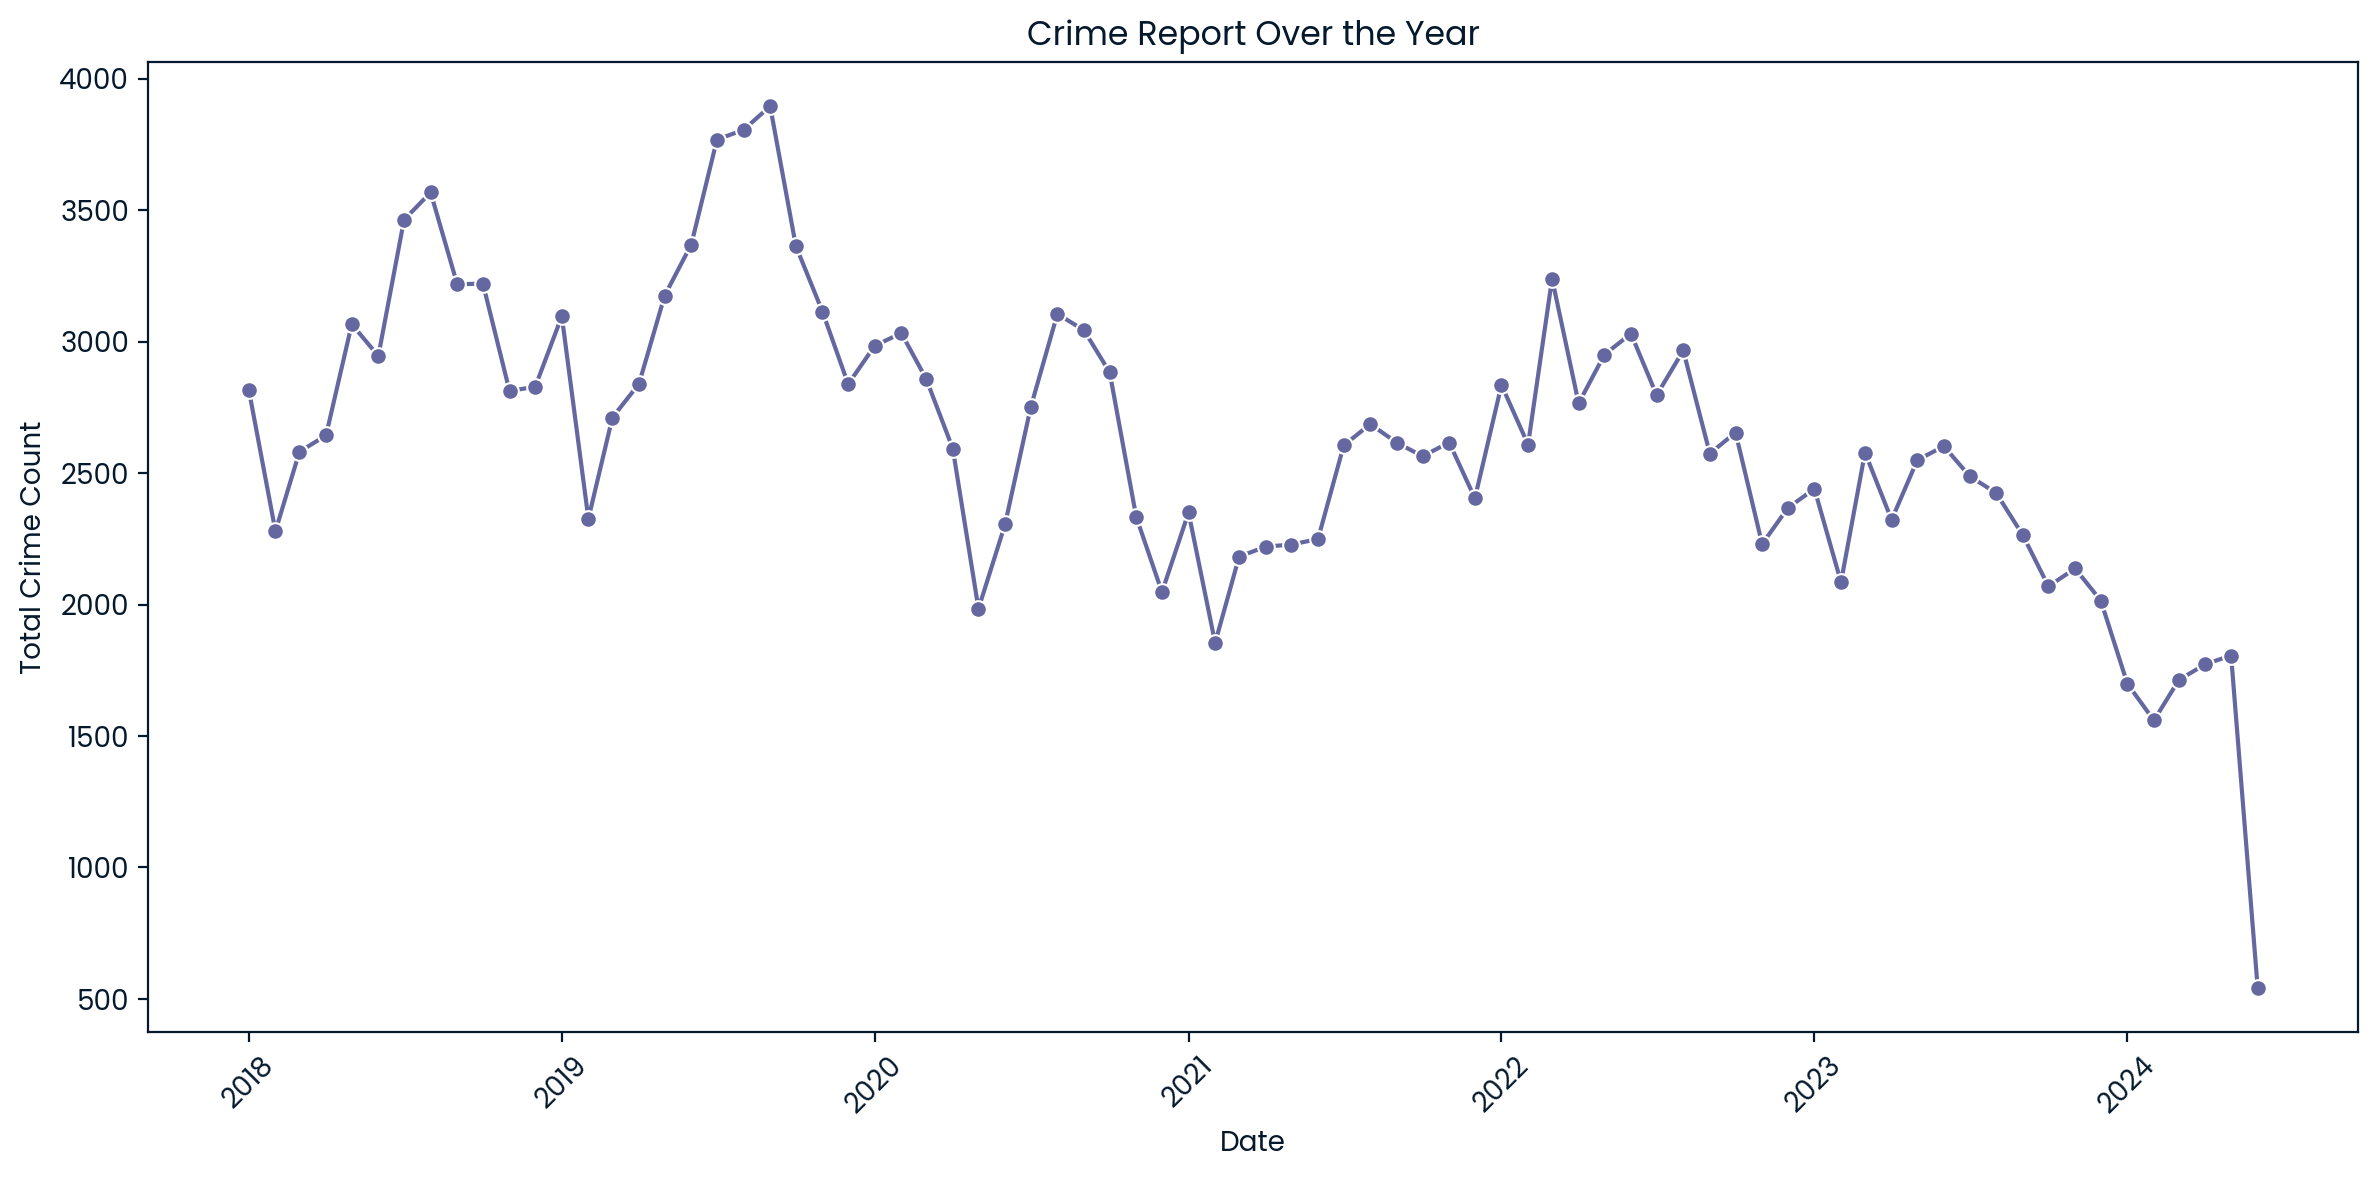

In [9]:
# Combine Year and Month into a datetime column
crimes['Date'] = pd.to_datetime(crimes[['Year', 'Month']].assign(DAY=1))

# Aggregate crime counts by date
date_crime_counts = crimes.groupby('Date')['Crime Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Crime Count", data=date_crime_counts, marker="o")
plt.title("Crime Report Over the Year")
plt.xlabel("Date")
plt.ylabel("Total Crime Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph depicts the annual fluctuation in reported crime incidents. The year 2019 exhibited the highest number of reported crimes within the observed timeframe.

### Crime Reports per Community

- Crime reports in top five (5) community

In [10]:
# Aggregate total crime counts by community
total_crime_counts = crimes.groupby('Community')['Crime Count'].sum().reset_index()

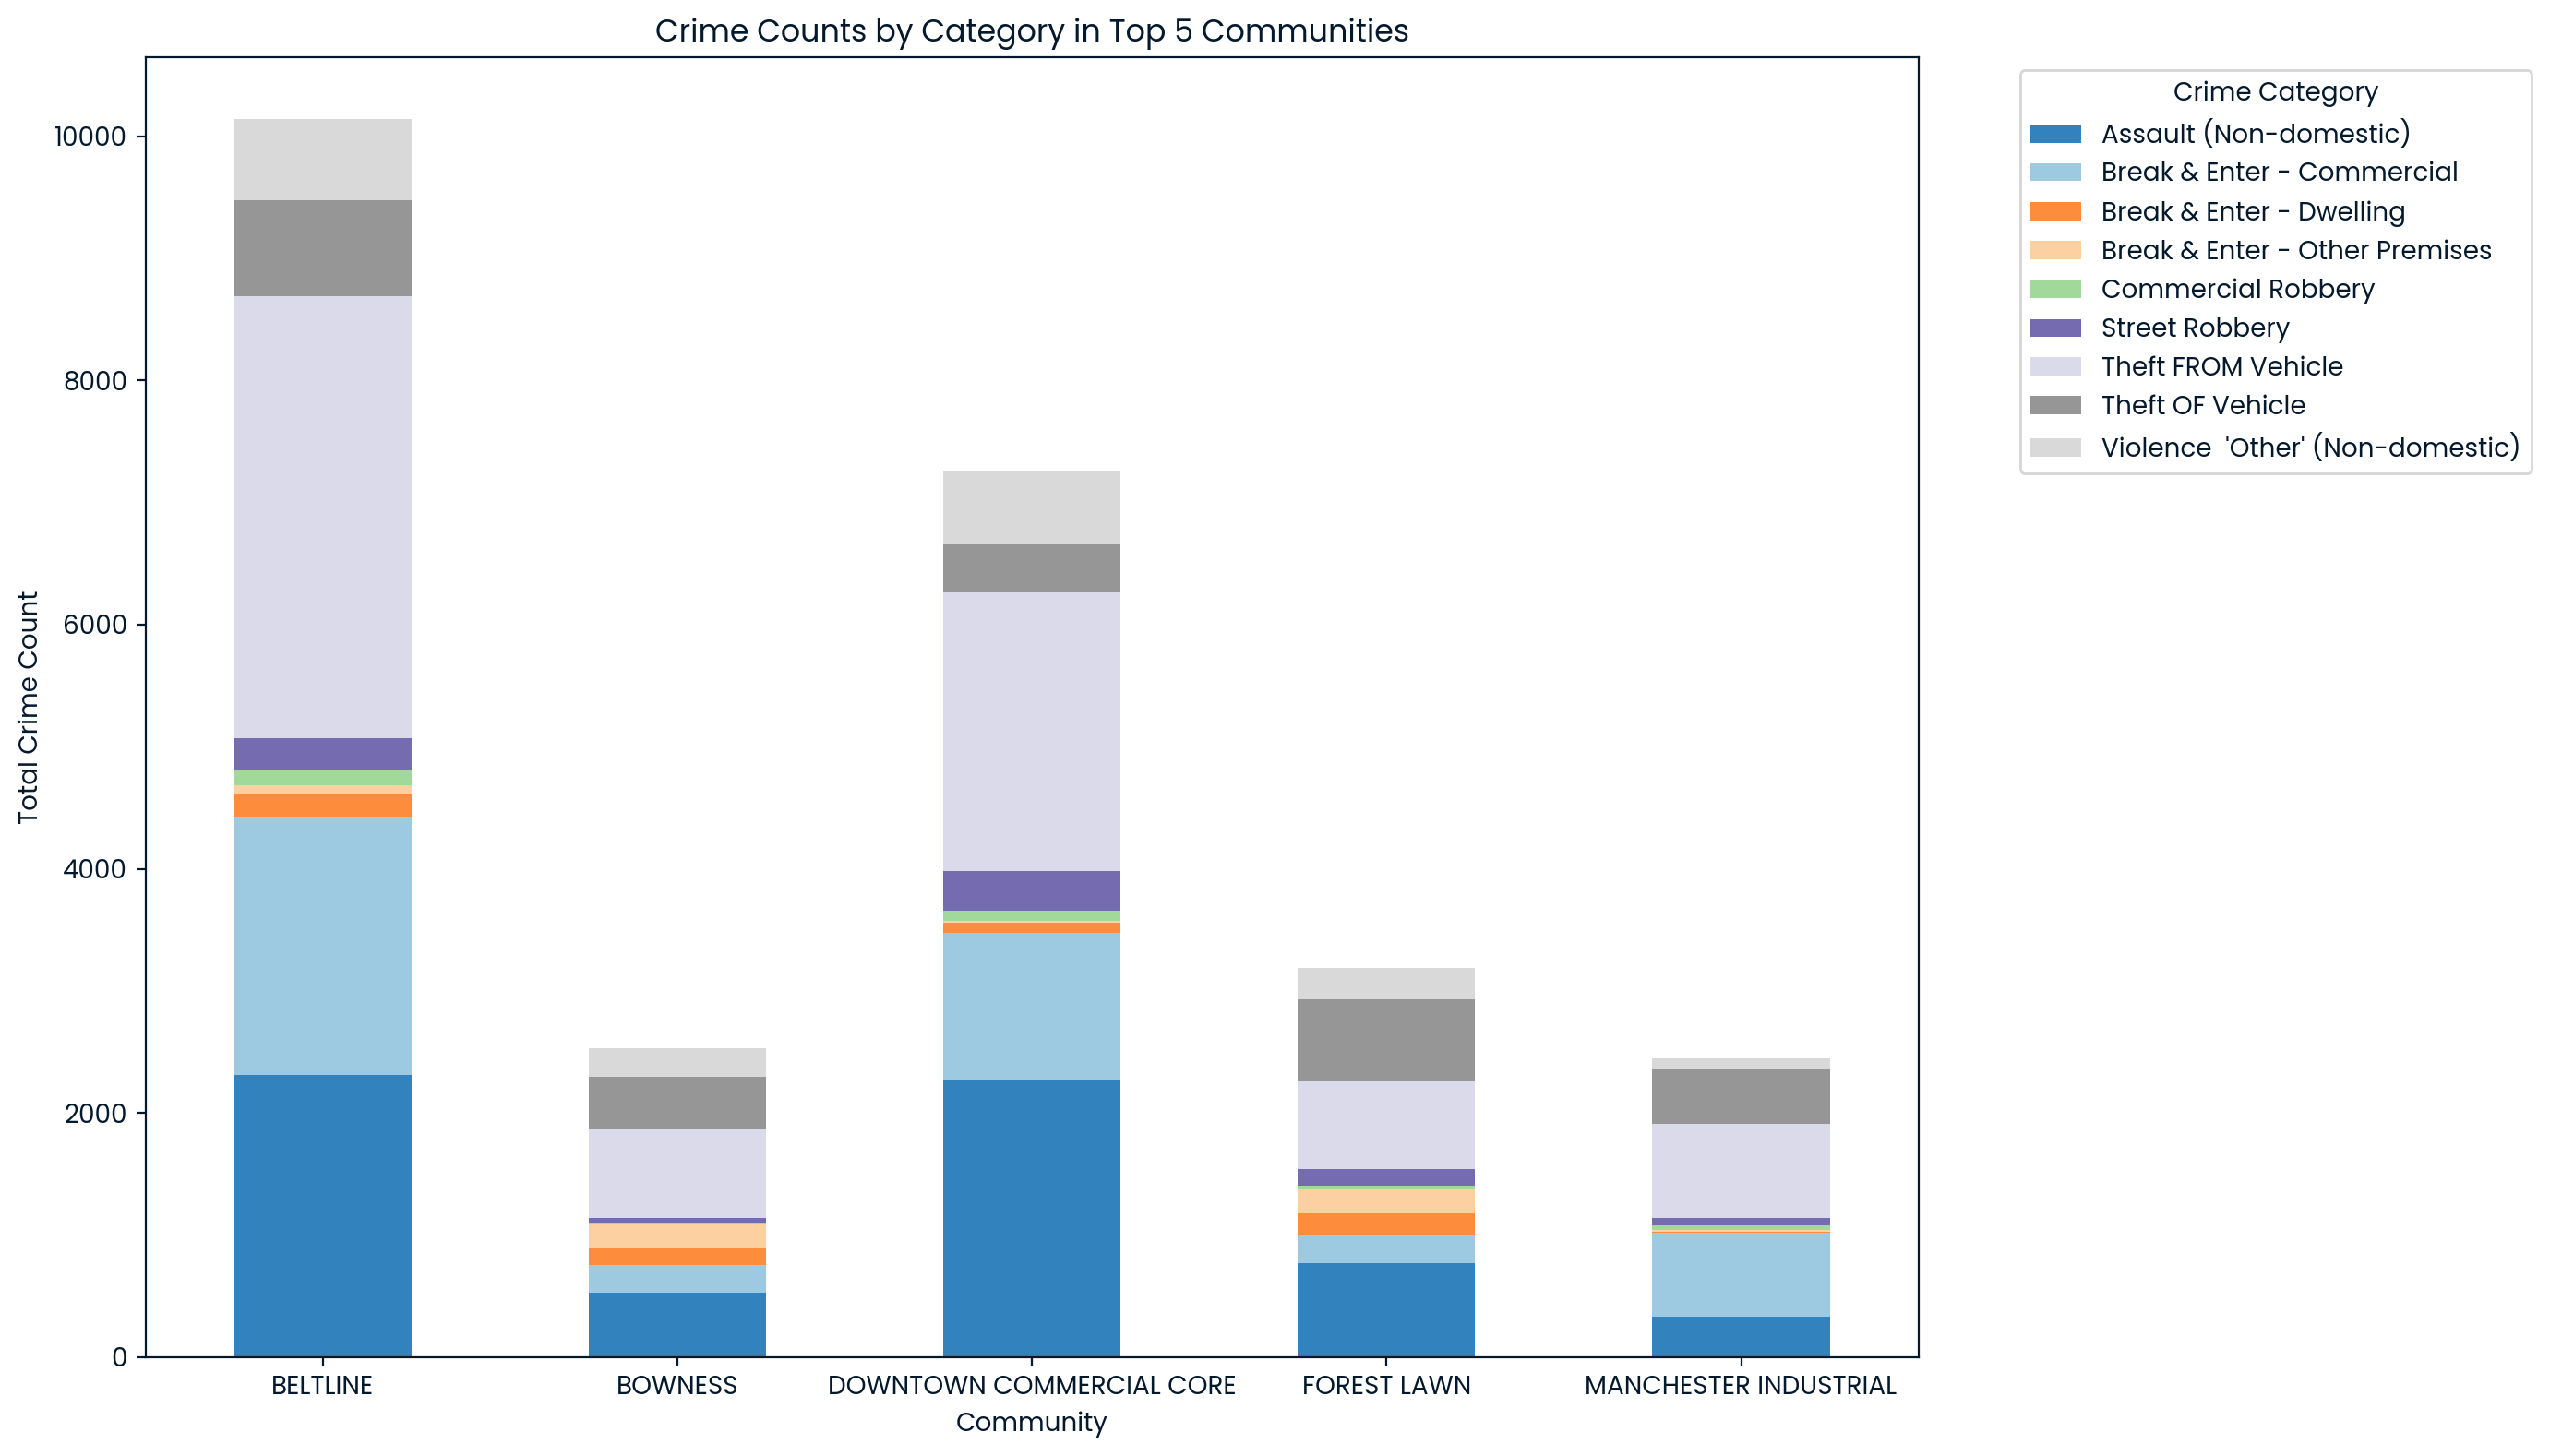

In [11]:
# Identify top 5 communities with highest total crime counts
top_5_communities = total_crime_counts.nlargest(5, 'Crime Count')['Community']

# Filter the dataset for only the top 5 communities
top_5_crimes = crimes[crimes['Community'].isin(top_5_communities)]

# Aggregate crime counts by community and crime category
top_5_crimes_aggregated = top_5_crimes.groupby(['Community', 'Category'])['Crime Count'].sum().unstack().fillna(0)

# Plotting
top_5_crimes_aggregated.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20c')
plt.title('Crime Counts by Category in Top 5 Communities')
plt.xlabel('Community')
plt.ylabel('Total Crime Count')
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- Crime reports on least five (5) communities

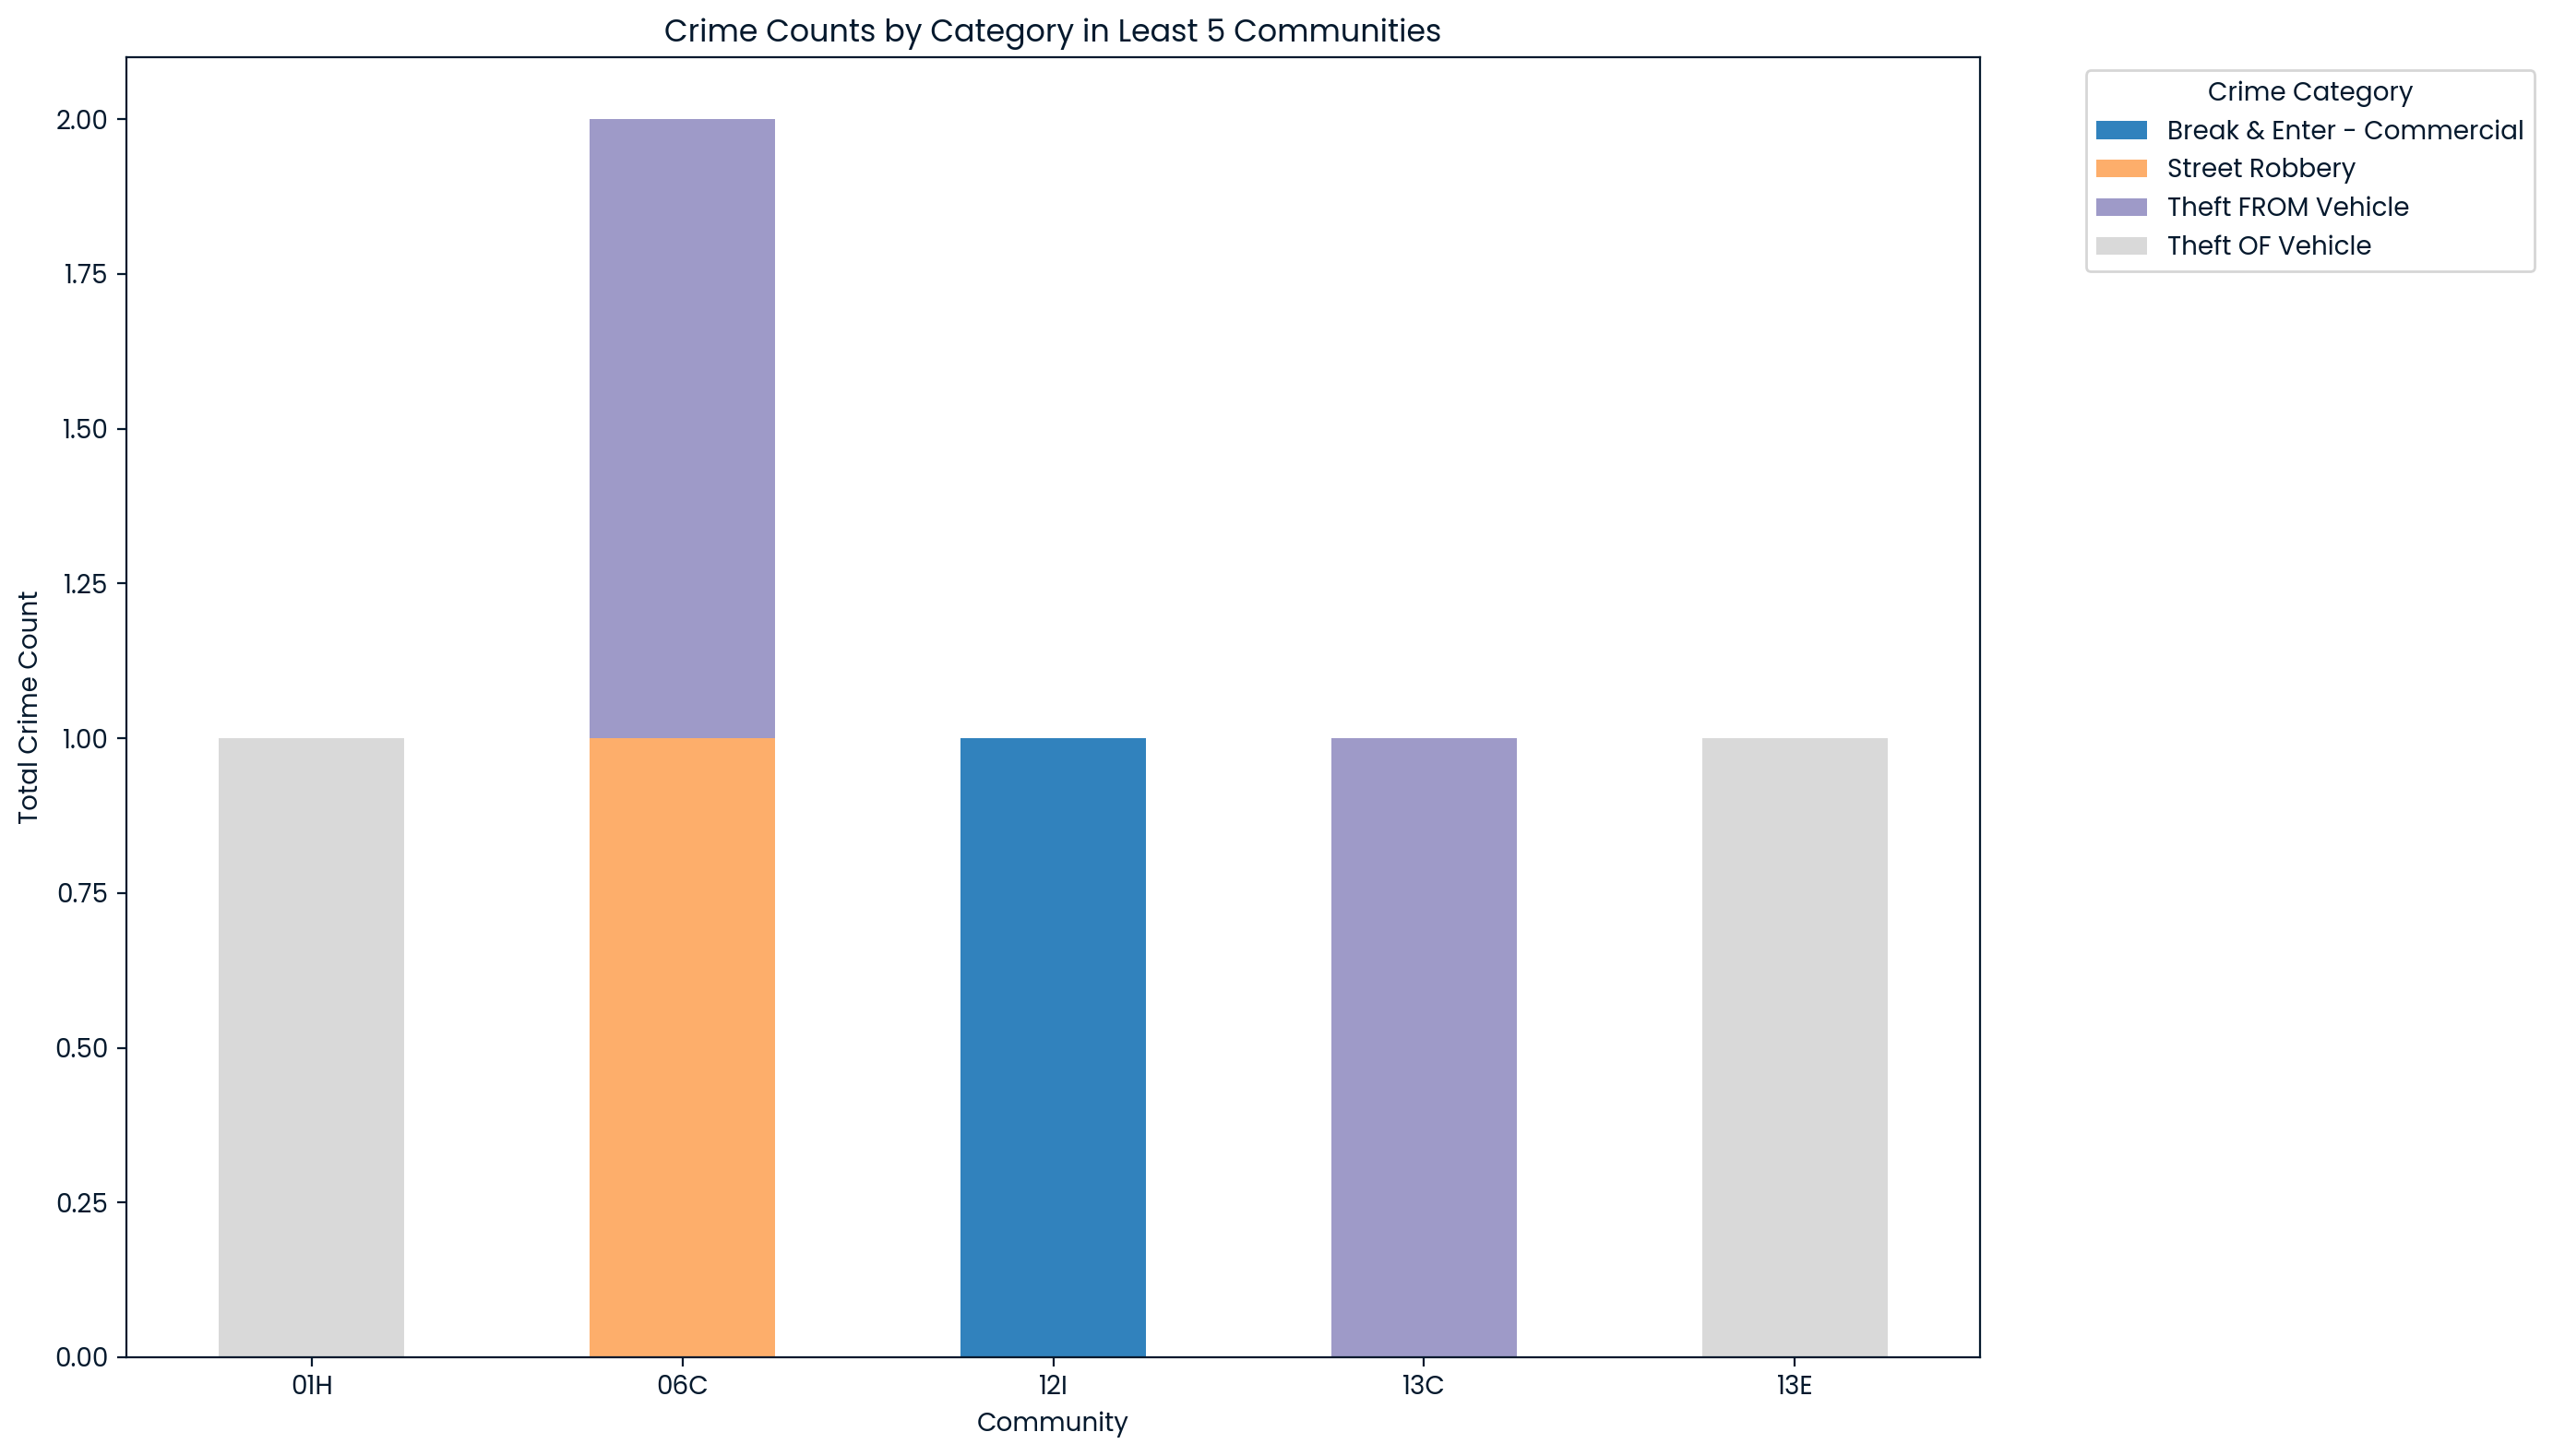

In [12]:
# Identify least 5 communities with lowest total crime counts
least_5_communities = total_crime_counts.nsmallest(5, 'Crime Count')['Community']

# Filter the dataset for only the least 5 communities
least_5_crimes = crimes[crimes['Community'].isin(least_5_communities)]

# Aggregate crime counts by community and crime category
least_5_crimes_aggregated = least_5_crimes.groupby(['Community', 'Category'])['Crime Count'].sum().unstack().fillna(0)

# Plotting
least_5_crimes_aggregated.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20c')
plt.title('Crime Counts by Category in Least 5 Communities')
plt.xlabel('Community')
plt.ylabel('Total Crime Count')
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

These visualizations highlight the need for targeted, community-specific crime prevention strategies that address the unique challenges of high-crime areas while maintaining the safety of low-crime communities.

### Crime Reports per Year

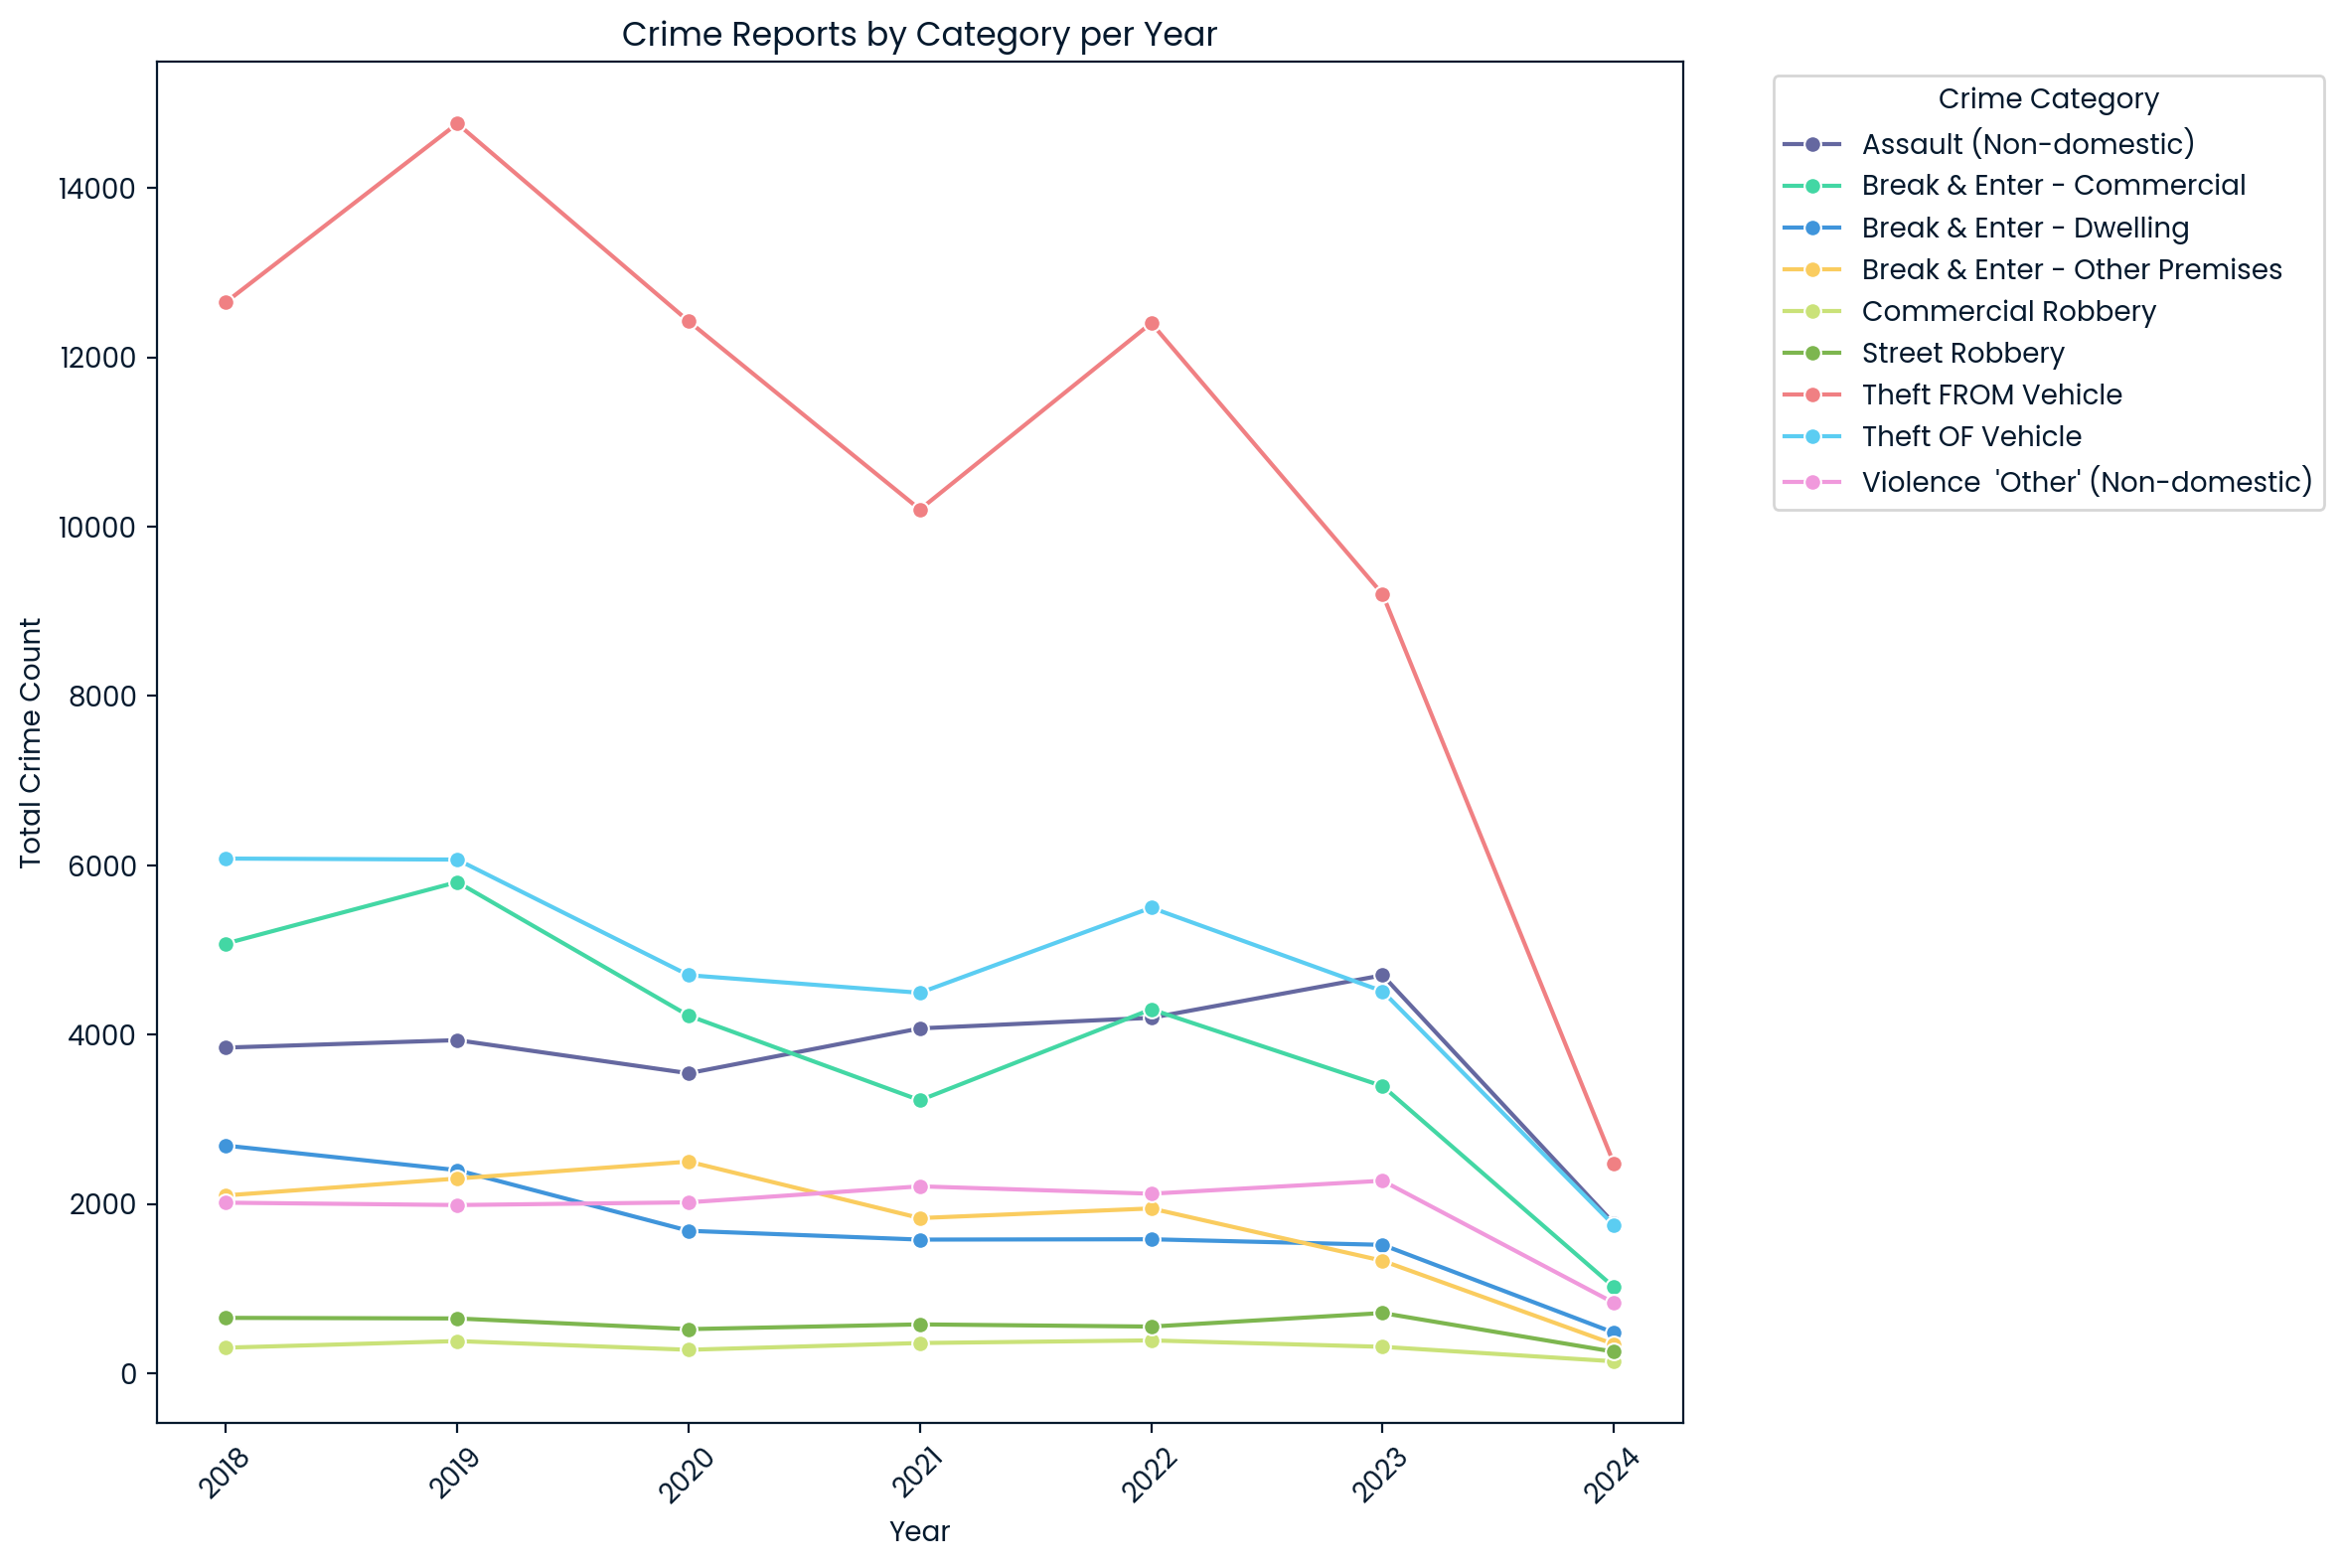

In [13]:
# Aggregate crime counts by year and category
year_category_crime_counts = crimes.groupby(['Year', 'Category'])['Crime Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=year_category_crime_counts, x='Year', y='Crime Count', hue='Category', marker='o')
plt.title('Crime Reports by Category per Year')
plt.xlabel('Year')
plt.ylabel('Total Crime Count')
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The data reveals a general downward trend in overall crime reports between 2018 and 2024. 'Theft from Vehicles' consistently emerges as the most prevalent crime category during this period, followed closely by 'Assault (Non-domestic)'. Although the overall crime rate is decreasing, certain crime types exhibit fluctuations. For example, 'Break and Enter' offenses, encompassing both commercial and residential properties, saw a marked increase in 2020 but subsequently declined. It is noteworthy that 'Street Robbery' incidents have been steadily rising in the latter half of the analyzed period.

## Prediction

Based on the visualized and analyzed data, numerous patterns, trends, and relationships have been identified. These insights will serve as the foundation for developing a robust predictive model.

In [14]:
# Drop the "Date" column
crimes = crimes.drop(columns=['Date'])

# Label Encoding
le = LabelEncoder()

# Columns
ot_cols = crimes.select_dtypes(include='object').columns

for col in ot_cols:
    crimes[col] = le.fit_transform(crimes[col])
    
crimes.head()

,Community,Category,Crime Count,Year,Month
0,0,0,1,2022,11
1,0,1,1,2019,6
2,0,1,1,2019,8
3,0,1,2,2020,3
4,0,1,2,2020,7


### Neural Network Model

- Prepare sequences for Long Short-Term Memory

But what is LSTM? It is a type of recurrent neural network (RNN) architecture specifically designed to handle sequential data. Unlike traditional RNNs, LSTMs have a more complex structure that allows them to learn long-term dependencies in the data. This makes them particularly well-suited for tasks like time series forecasting, where understanding past data is crucial for predicting future values.

For context, we will use an LSTM to model the time series of crime counts, capturing seasonal patterns, trends, and other temporal dependencies that might influence future crime rates.

In [15]:
# Preparation for sequences
def sequences(data, sl):
    xs = []
    ys = []
    for i in range(len(data) - sl):
        x = data.iloc[i:(i + sl)].to_numpy()
        y = data.iloc[i + sl]['Crime Count']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

- Apply the `sequences` fuction

In [16]:
sl = 3
X, y = sequences(crimes, sl)

- Train, Test, Split

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

- Building and training the LSTM model

In [18]:
# The LSTM model
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(sl, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=16)

Epoch 1/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2056.0562 - val_loss: 11.5436
Epoch 2/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 11.1764 - val_loss: 10.5088
Epoch 3/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 11.0365 - val_loss: 14.0375
Epoch 4/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 13.3522 - val_loss: 12.9481
Epoch 5/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 13.1515 - val_loss: 9.1241
Epoch 6/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.3371 - val_loss: 6.0656
Epoch 7/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.2262 - val_loss: 6.1277
Epoch 8/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.5529 - val_loss: 5.5090
Epoch 9/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.1123 - val_loss: 5.2463
Epoch 10/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.9629 - val_loss: 5.6702
Epoch 11/100
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.3585 - val_loss: 5.8121
Epoch 12

- Visualize the losses
    - Training loss
    - Validation Loss 

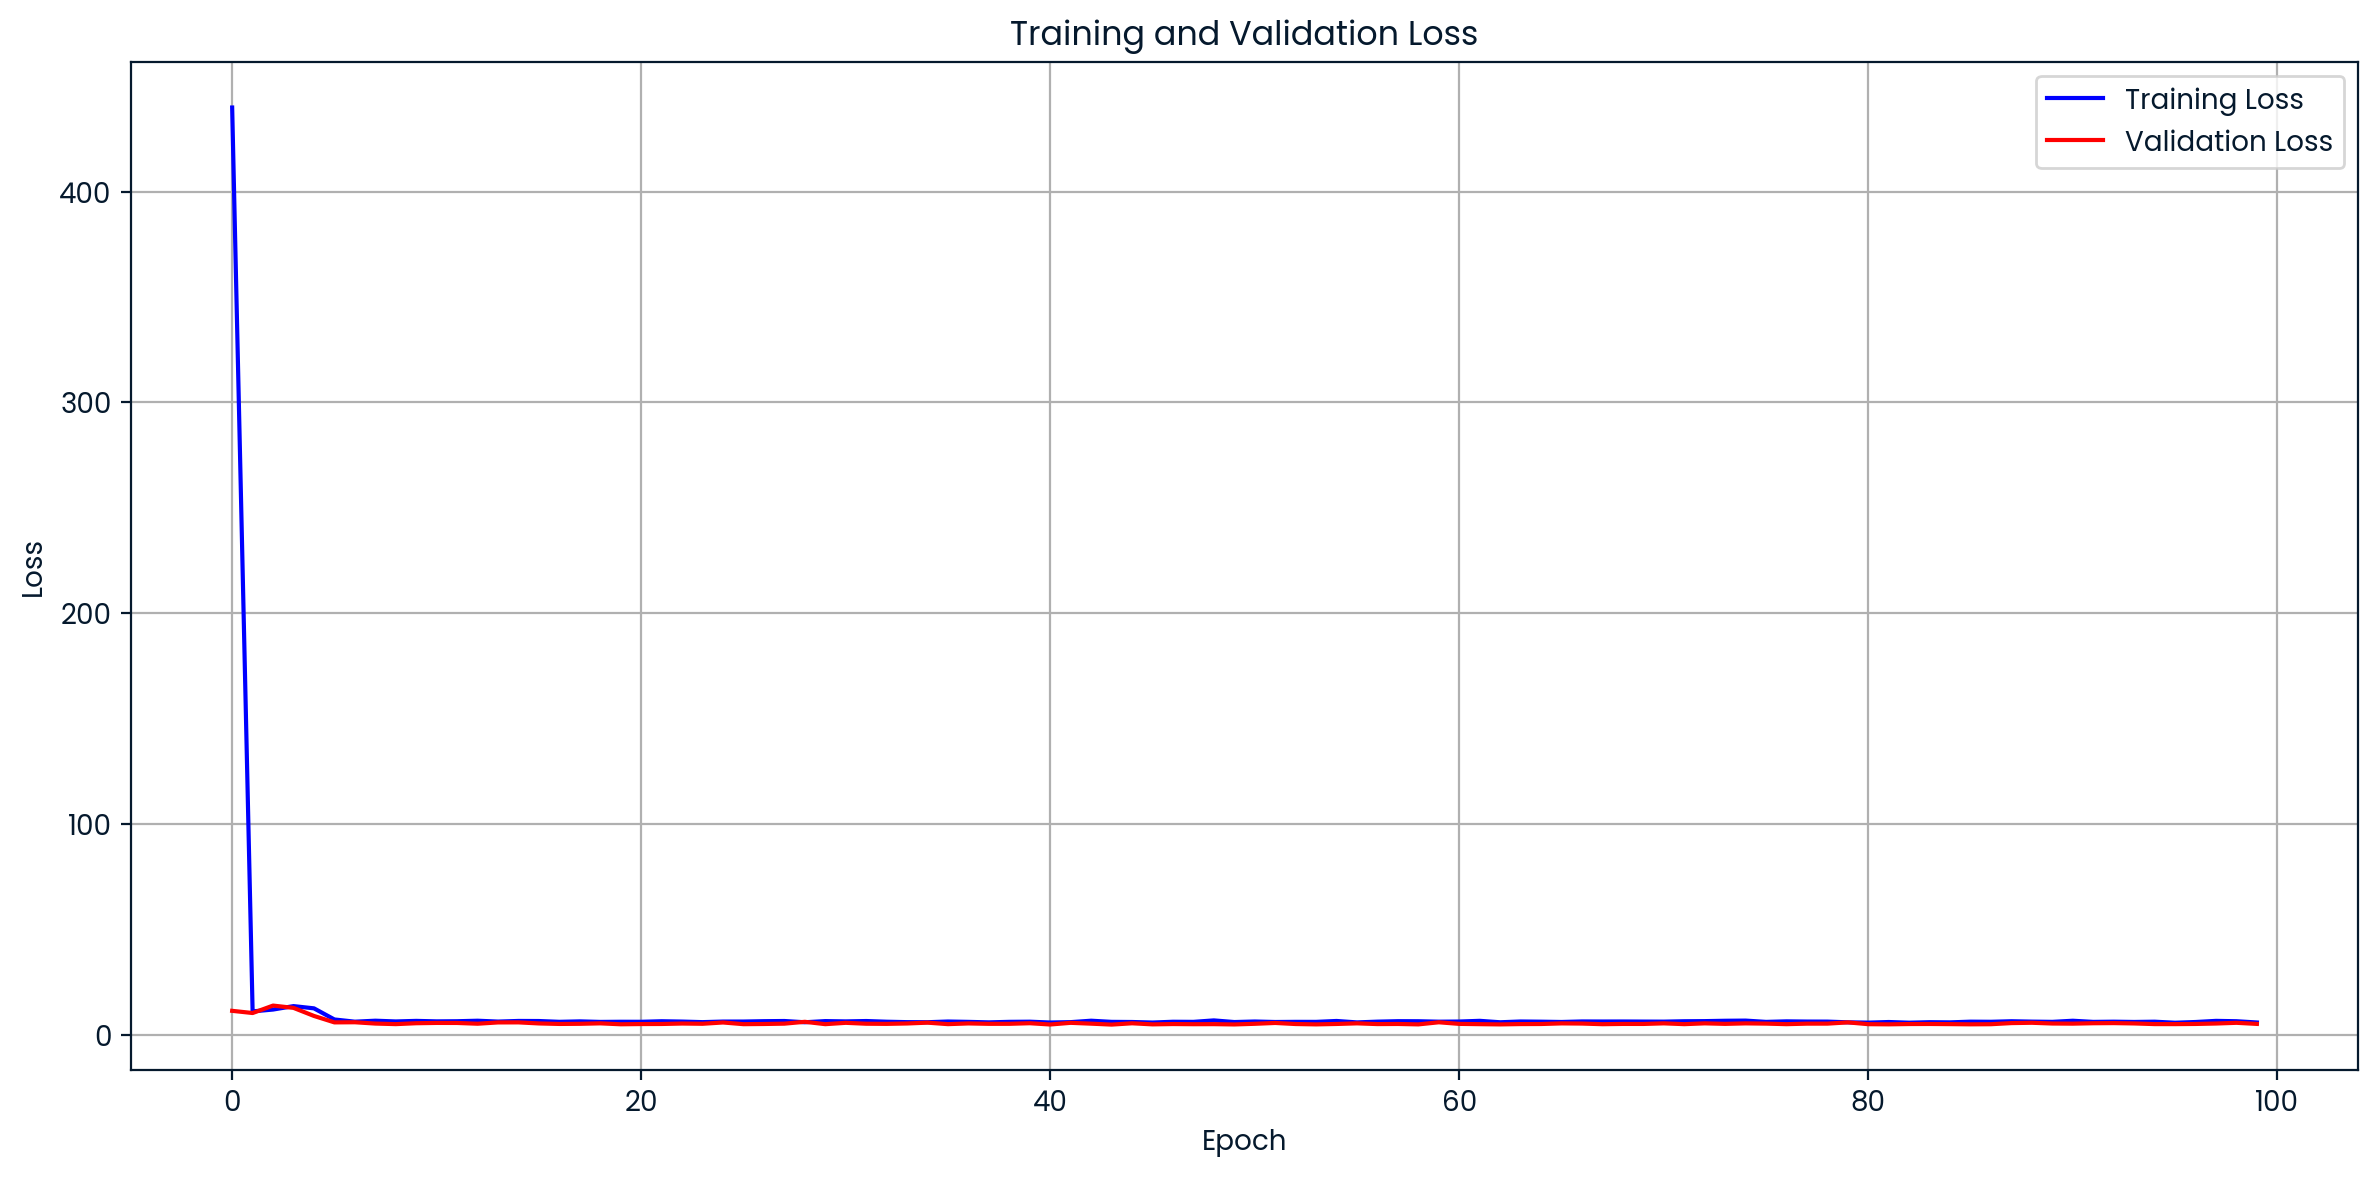

In [19]:
# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Initially, both training and validation loss metrics exhibit high values. While the training loss decreases rapidly during the early epochs, suggesting effective learning, this steep decline might indicate potential overfitting. Conversely, the validation loss initially decreases but subsequently plateaus and begins to rise, confirming overfitting. The model is becoming overly specialized in the training data, compromising its ability to generalize to unseen data.

To address overfitting, consider adjusting hyperparameters such as learning rate, batch size, and optimizer, as well as implementing regularization techniques like L1 or L2 regularization.

- Evaluate the model

In [20]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 4.0676
Test Loss: 4.346866130828857


The observed test loss of 4.35 indicates suboptimal model performance on unseen data. This high value suggests potential issues such as overfitting, underfitting, or deficiencies in the model's architecture or hyperparameters.

- Prediction

In [21]:
y_pred = model.predict(X_test)
print(f"Prediction: {y_pred.flatten()}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Prediction: [1.5633541 2.6092305 2.8829074 ... 2.2394142 3.2044551 1.717447 ]


- True values

In [22]:
print(f"True Values: {y_test.flatten()}")

True Values: [1 4 2 ... 2 4 1]


## Model Evaluation

### Value Comparison

- Actual vs Predicted values

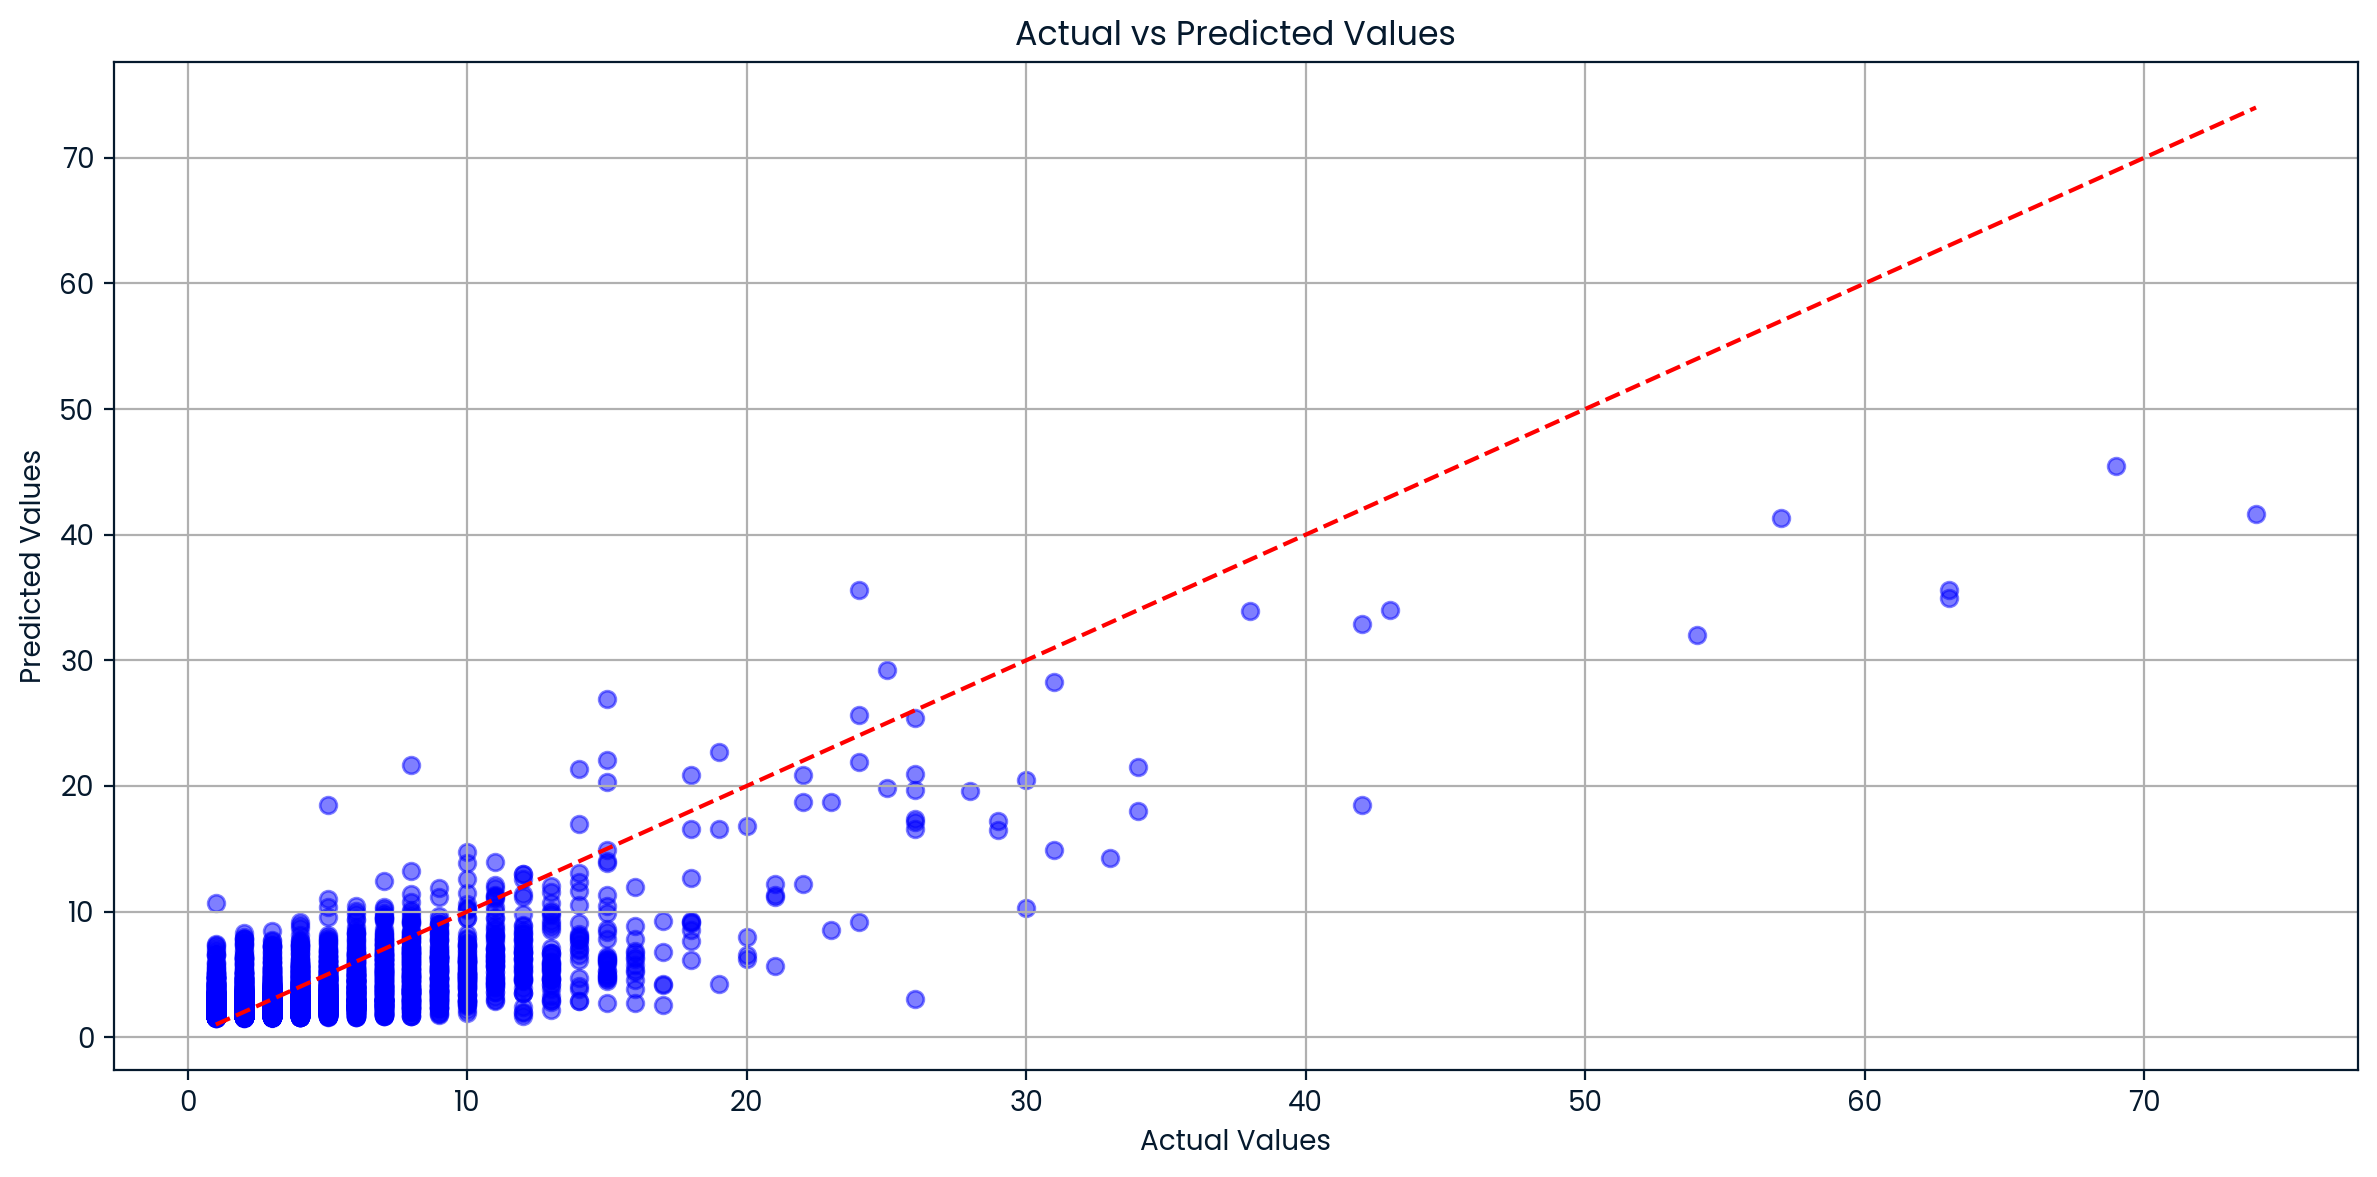

In [23]:
# Flatten arrays if they are not already
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.5, color='blue')
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot illustrates a general positive correlation between actual and predicted values, suggesting the model has captured some underlying patterns in the data. However, significant scatter around the ideal diagonal line indicates prediction errors. The model's accuracy appears to diminish for higher actual values, as evidenced by the wider dispersion of data points in this region.

### Residual
- Residual vs Predicted values

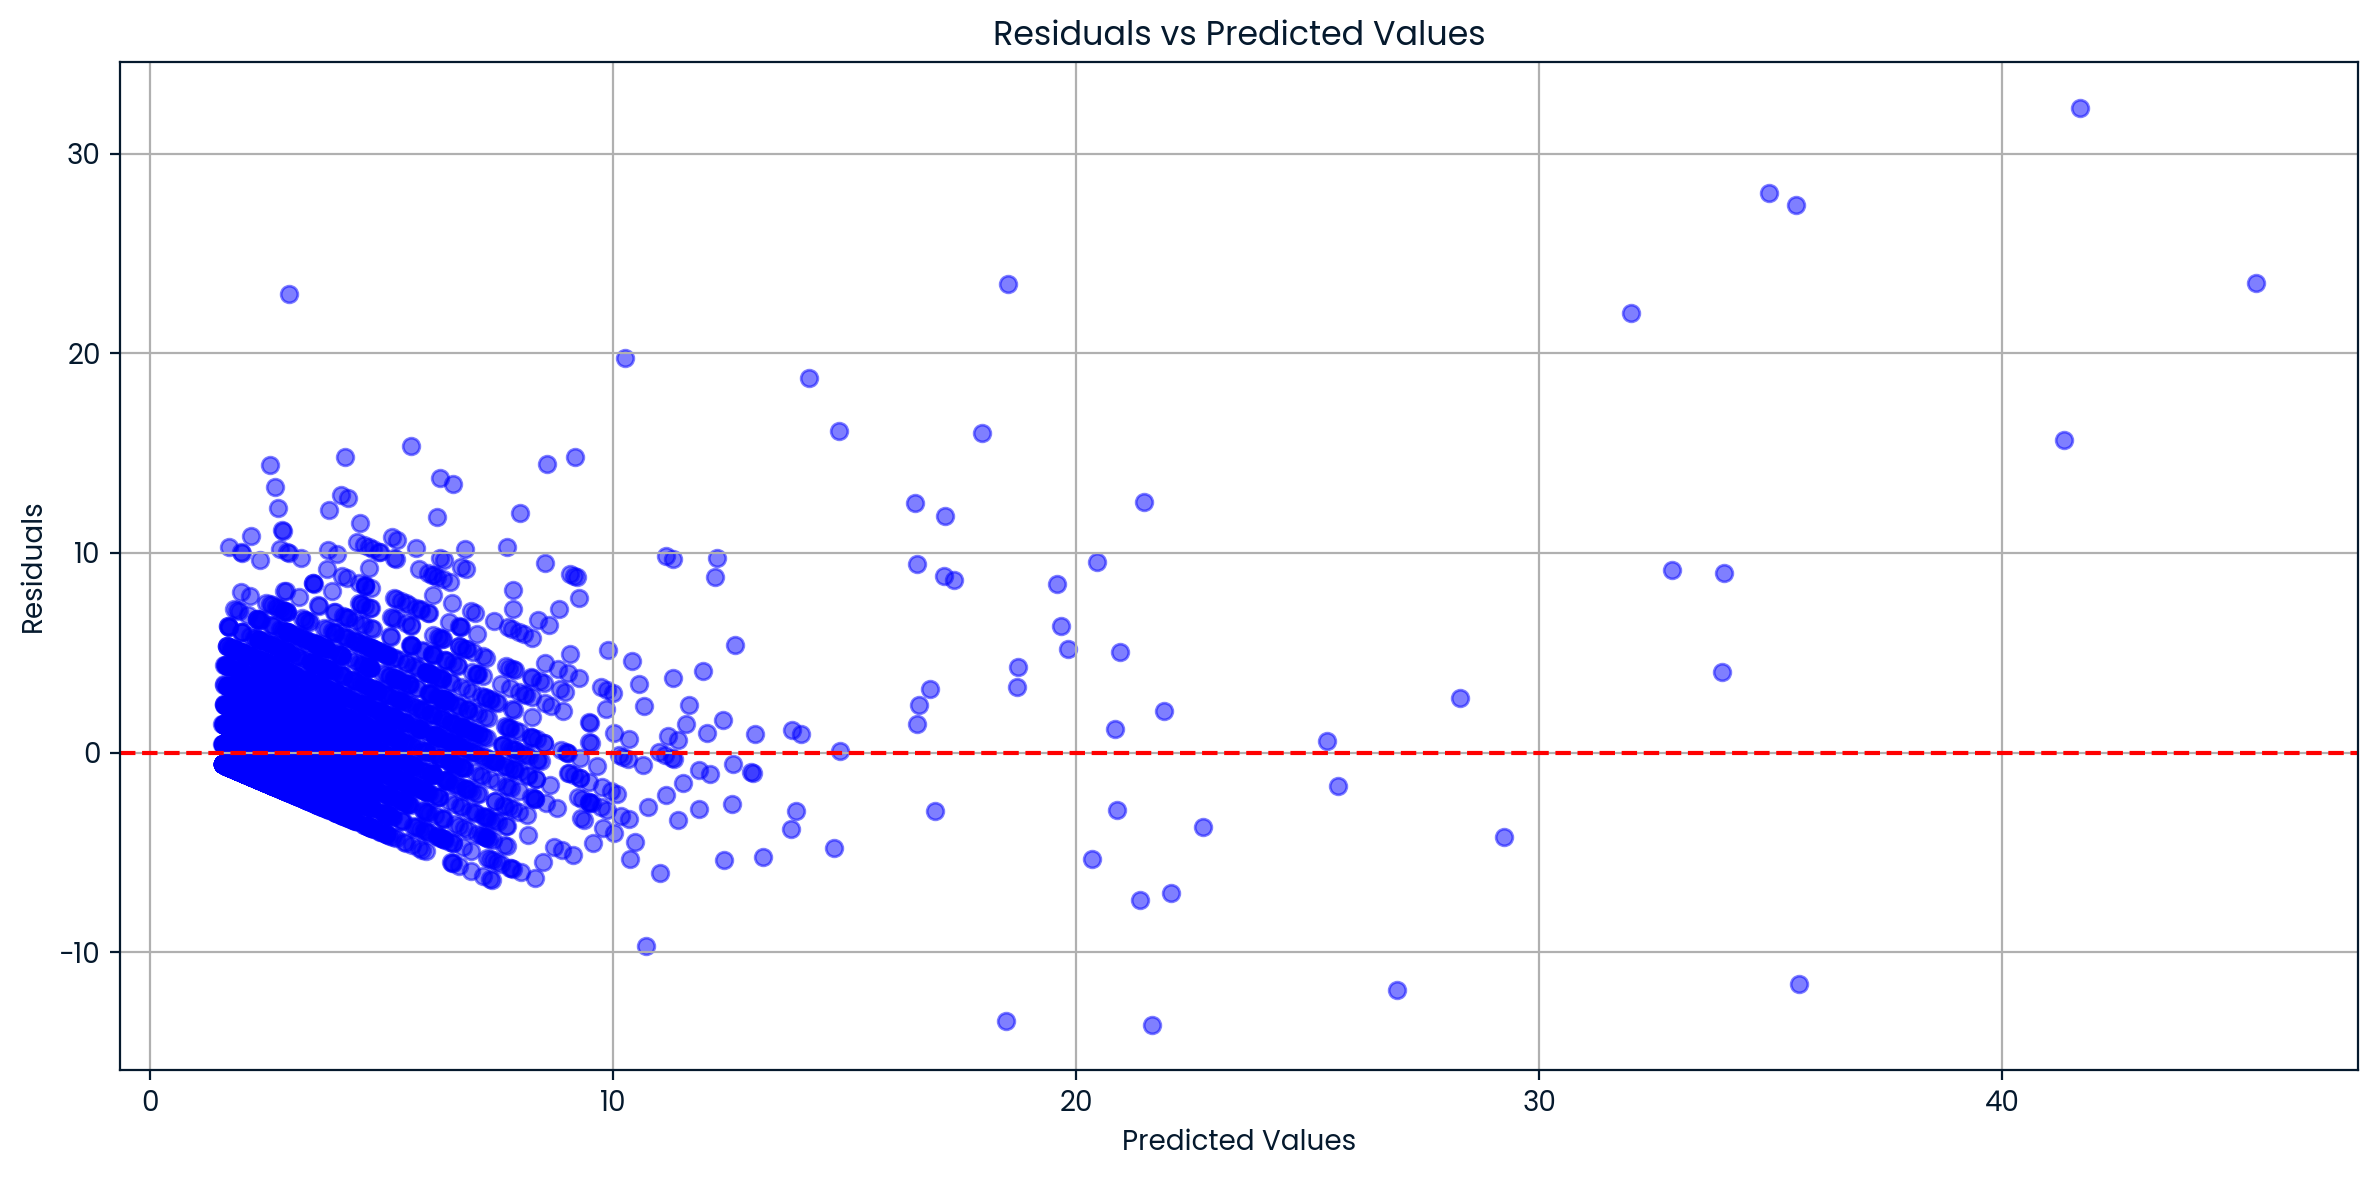

In [24]:
# Calculate residuals
residuals = y_test_flat - y_pred_flat

# Plotting residuals
plt.figure(figsize=(12, 6))

# Residuals vs Predicted Values
plt.scatter(y_pred_flat, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

The residual plot exhibits heteroscedasticity, indicated by the fan-like dispersion of data points. This suggests inconsistent error terms, potentially compromising prediction reliability. A subtle pattern within the residuals hints at a potential non-linear relationship that the current model might not adequately capture. Additionally, a few outliers are evident, which could be distorting the model's performance. Overall, these findings suggest opportunities for model improvement by addressing heteroscedasticity, non-linearity, and outlier influence.


- Histogram of Residuals

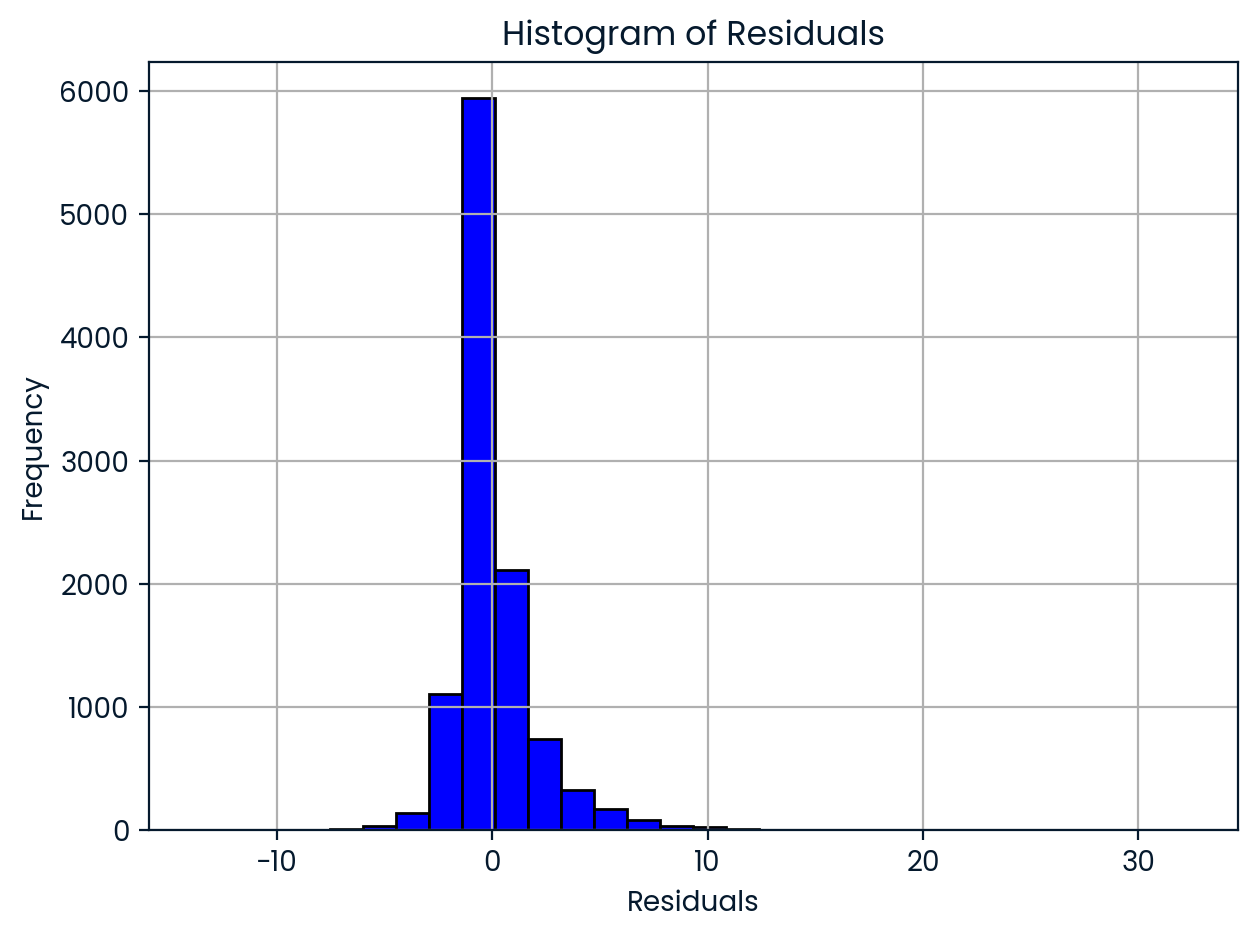

In [25]:
# Histogram of Residuals
plt.hist(residuals, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram reveals a distribution of residuals that is heavily skewed to the right. This indicates that the model's errors are not normally distrubuted. There appears to be a longer tail in the positive residual direcion, suggesting the presence of the potential outliers or influential data points that might be impacting the model's performance. Visually, the mean of the residual seems to be close to zero, which is desirable. However, the variance appears to be relatively high due to the spread of the data. Overall, the non-normal distribution of residuals and the presence of potential outliers suggest that the model may not be caThe residual histogram exhibits a pronounced right skew, indicating non-normal error distribution. A prominent tail in the positive residual region suggests the presence of potential outliers or influential data points. While the mean residual is approximately zero, the variance is relatively high. These characteristics collectively imply that the model might not adequately capture the underlying data patterns, potentially leading to biased and less accurate predictions.
